In [2]:
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
IPythonConsole.ipython_useSVG=False  #< set this to False if you want PNGs instead of SVGs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import numpy as np
from rdkit import DataStructs
from sklearn.decomposition import PCA
import random
import sqlite3

In [3]:
drugex_base_smiles = pd.read_csv("../data/drugex_selfies_base_80k.csv", header=None)
drugex_base_smiles = drugex_base_smiles[0].to_list()

In [35]:
highs_a2a = []
for i in range(8):
    cnx = sqlite3.connect(f'/home/julius/thesis/rxitect/logs/mogfn/drugex_v2_tb_beta_96_lr_5e-4/generated_mols_{i}.db')
    df = pd.read_sql_query("SELECT * FROM results2", cnx)
    highs_a2a.extend(df[-2_500:]["smi"])
    cnx.close()

In [5]:
drugex_base_smiles = list(set(drugex_base_smiles))

In [ ]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

In [44]:
def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol,n_bits))
    return fp_list

def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), np.int_)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [ ]:
drugex_base_fp_list = fp_list_from_smiles_list(drugex_base_smiles)

In [ ]:
gfn_base_fp_list = fp_list_from_smiles_list(highs_a2a)

In [ ]:
final_fp_list = drugex_base_fp_list + gfn_base_fp_list

In [ ]:
hue_list = [0 for _ in range(len(drugex_base_smiles))] + [1 for _ in range(len(gfn_base_fp_list))]

In [ ]:
pca = PCA(n_components=50)
fcrds = pca.fit_transform(final_fp_list) 

In [ ]:
from sklearn.manifold import TSNE
%time crds_embedded = TSNE(n_components=2).fit_transform(fcrds)

In [ ]:
tsne_df = pd.DataFrame(crds_embedded,columns=["X","Y"])
tsne_df['is_active'] = hue_list

In [ ]:
ax = sns.scatterplot(data=tsne_df.query("is_active == 0"),x="X",y="Y",color='orange')
ax = sns.scatterplot(data=tsne_df.query("is_active == 1"),x="X",y="Y",color='teal')
ax.legend(labels=['DrugEx+R', 'GFlowNet@TB'])
ax.set_title("Chemical space generated candidates DrugEx+R vs. GFlowNet")
plt.savefig("../reports/drugex_plus_r_vs_gflownet_chemspace.png")

In [9]:
drugex_base_smiles_sc = pd.read_csv("../data/drugex_selfies_base_80K_scores.csv")

In [10]:
drugex_base_smiles_sc

,A2A,A1,hERG
0,1.000000,0.951085,0.303150
1,0.741273,0.731796,0.321411
2,0.594319,0.638463,0.304440
3,0.750337,0.819254,0.335920
4,0.796947,0.783132,0.259652
...,...,...,...
79995,0.825938,0.931182,0.393643
79996,0.785901,0.776818,0.410714
79997,0.758579,0.815604,0.305429
79998,0.764104,0.837759,0.398378


In [11]:
drugex_base_smiles_idx = pd.read_csv("../data/drugex_selfies_base_80k.csv", header=None)

In [12]:
drugex_base_smiles_idx = drugex_base_smiles_idx[0].drop_duplicates().index

In [13]:
drugex_unique_scores = drugex_base_smiles_sc.iloc[drugex_base_smiles_idx]

<AxesSubplot: ylabel='Density'>

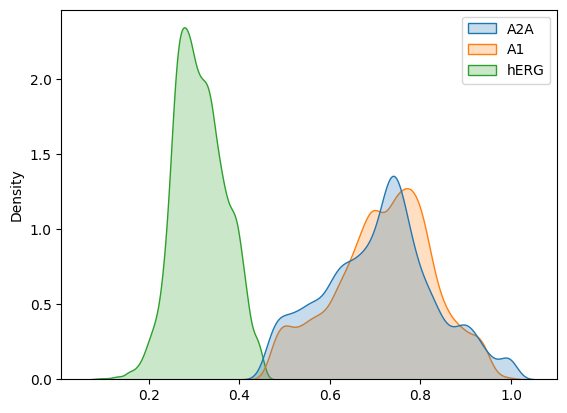

In [14]:
sns.kdeplot(drugex_unique_scores, fill=True)

In [15]:
highs_a2a = []
for i in range(8):
    cnx = sqlite3.connect(f'/home/julius/thesis/rxitect/logs/mogfn/drugex_v2_tb_beta_96_lr_5e-4/generated_mols_{i}.db')
    df = pd.read_sql_query("SELECT * FROM results2", cnx)
    highs_a2a.extend(df[-2_500:]["fr_0"])
    cnx.close()

highs_a1 = []
for i in range(8):
    cnx = sqlite3.connect(f'/home/julius/thesis/rxitect/logs/mogfn/drugex_v2_tb_beta_96_lr_5e-4/generated_mols_{i}.db')
    df = pd.read_sql_query("SELECT * FROM results2", cnx)
    highs_a1.extend(df[-2_500:]["fr_1"])
    cnx.close()

highs_herg = []
for i in range(8):
    cnx = sqlite3.connect(f'/home/julius/thesis/rxitect/logs/mogfn/drugex_v2_tb_beta_96_lr_5e-4/generated_mols_{i}.db')
    df = pd.read_sql_query("SELECT * FROM results2", cnx)
    highs_herg.extend(df[-2_500:]["fr_2"])
    cnx.close()

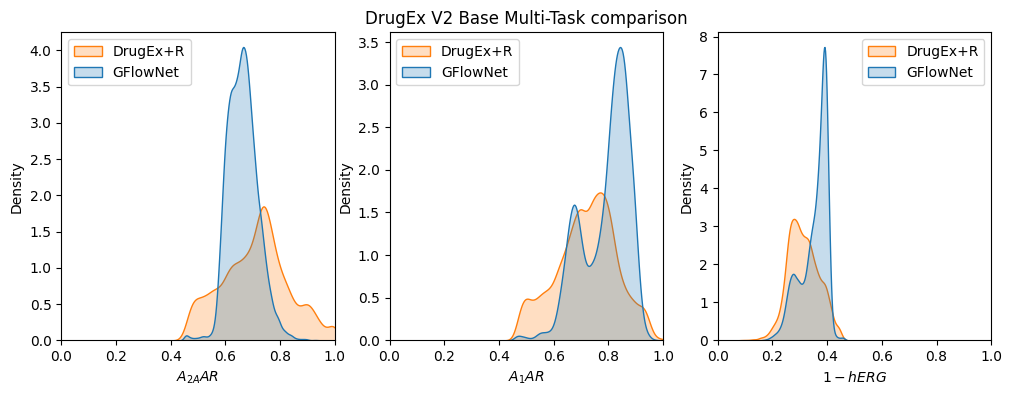

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
sns.kdeplot([highs_a2a, drugex_unique_scores["A2A"]], ax=ax[0], fill=True)
ax[0].legend(labels=["DrugEx+R", "GFlowNet"], loc="upper left")
ax[0].set_xlabel("$A_{2A}AR$")
ax[0].set_xlim([0, 1])
sns.kdeplot([highs_a1, drugex_unique_scores["A1"]], ax=ax[1], fill=True)
ax[1].legend(labels=["DrugEx+R", "GFlowNet"], loc="upper left")
ax[1].set_xlabel("$A_{1}AR$")
ax[1].set_xlim([0, 1])
sns.kdeplot([highs_herg, drugex_unique_scores["hERG"]], ax=ax[2], fill=True)
ax[2].legend(labels=["DrugEx+R", "GFlowNet"])
ax[2].set_xlabel("$1-hERG$")
ax[2].set_xlim([0, 1])
ax[1].set_title("DrugEx V2 Base Multi-Task comparison")
fig.savefig("../reports/drugex_v2_base_mt_comparison")

In [17]:
from rdkit.Chem import AllChem, Mol
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint, GetBTFingerprint
from rdkit.Chem.Pharm2D import Generate, Gobbi_Pharm2D


class _FingerprintCalculator:
    """
    Calculate the fingerprint while avoiding a series of if-else.
    See recipe 8.21 of the book "Python Cookbook".
    To support a new type of fingerprint, just add a function "get_fpname(self, mol)".
    """

    def get_fingerprint(self, mol: Mol, fp_type: str):
        method_name = 'get_' + fp_type
        method = getattr(self, method_name)
        if method is None:
            raise Exception(f'{fp_type} is not a supported fingerprint type.')
        return method(mol)

    def get_AP(self, mol: Mol):
        return AllChem.GetAtomPairFingerprint(mol, maxLength=10)

    def get_PHCO(self, mol: Mol):
        return Generate.Gen2DFingerprint(mol, Gobbi_Pharm2D.factory)

    def get_BPF(self, mol: Mol):
        return GetBPFingerprint(mol)

    def get_BTF(self, mol: Mol):
        return GetBTFingerprint(mol)

    def get_PATH(self, mol: Mol):
        return AllChem.RDKFingerprint(mol)

    def get_ECFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2)

    def get_ECFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3)

    def get_FCFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2, useFeatures=True)

    def get_FCFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3, useFeatures=True)


def get_fingerprint(mol: Mol, fp_type: str):
    return _FingerprintCalculator().get_fingerprint(mol=mol, fp_type=fp_type)

In [18]:
from typing import *
from logging import getLogger


logger = getLogger()

def get_mols(smiles_list: Collection[str]) -> Collection[Chem.Mol]:
    return [Chem.MolFromSmiles(smi) for smi in tqdm(smiles_list, desc="Transforming SMILES to RDKit Mols")]

# def get_fingerprints(mols: Collection[Mol], fp_type: str = "ECFP6"):
#     return [get_fingerprint(m, fp_type) for m in tqdm(mols, desc="Getting FPs from Mols")]

def get_fingerprints(mols: Iterable[Chem.Mol], radius=3, length=2048):
    """
    Converts molecules to ECFP bitvectors.

    Args:
        mols: RDKit molecules
        radius: ECFP fingerprint radius
        length: number of bits

    Returns: a list of fingerprints
    """
    return [AllChem.GetMorganFingerprintAsBitVect(m, radius, length) for m in mols]

def calculate_internal_pairwise_similarities(smiles_list: Collection[str]) -> np.array:
    """
    Computes the pairwise similarities of the provided list of smiles against itself.

    Returns:
        Symmetric matrix of pairwise similarities. Diagonal is set to zero.
    """
    if len(smiles_list) > 10000:
        logger.warning(f'Calculating internal similarity on large set of '
                       f'SMILES strings ({len(smiles_list)})')

    mols = get_mols(smiles_list)
    fps = get_fingerprints(mols)
    nfps = len(fps)

    similarities = np.zeros((nfps, nfps))

    for i in tqdm(range(1, nfps)):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i])
        similarities[i, :i] = sims
        similarities[:i, i] = sims

    return similarities 

In [19]:
drugex_base_sims = calculate_internal_pairwise_similarities(drugex_base_smiles)

Calculating internal similarity on large set of SMILES strings (16629)


Transforming SMILES to RDKit Mols:   0%|          | 0/16629 [00:00<?, ?it/s]

  0%|          | 0/16628 [00:00<?, ?it/s]

In [48]:
drugex_mean_sim_per_mol = np.mean(drugex_base_sims, axis=1)

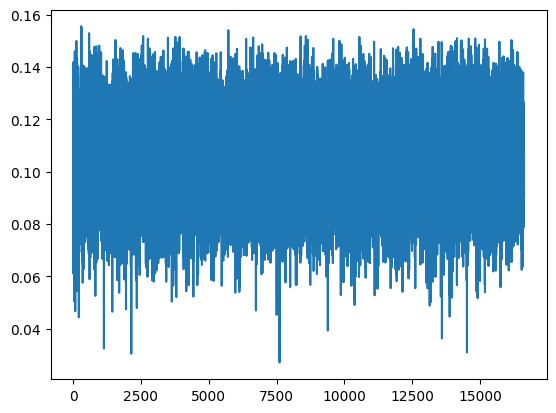

In [33]:
plt.plot(_)

In [36]:
highs_a2a = list(set(highs_a2a))

In [38]:
gfn_base_sims = calculate_internal_pairwise_similarities(highs_a2a)

Calculating internal similarity on large set of SMILES strings (19999)


Transforming SMILES to RDKit Mols:   0%|          | 0/19999 [00:00<?, ?it/s]

  0%|          | 0/19998 [00:00<?, ?it/s]

In [40]:
gfn_mean_sim_per_mol = np.mean(gfn_base_sims, axis=1)

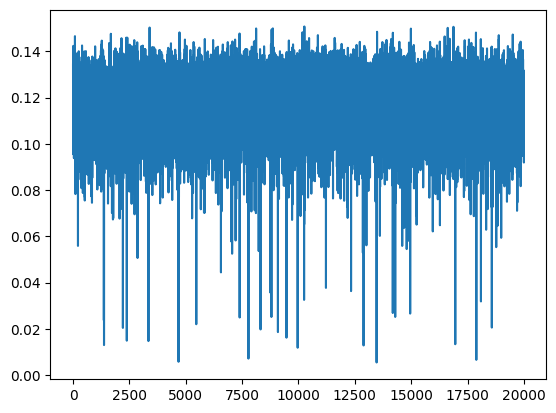

In [58]:
plt.plot(gfn_mean_sim_per_mol)

<AxesSubplot: ylabel='Density'>

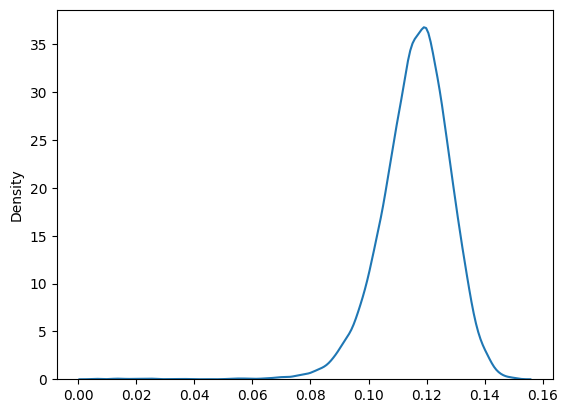

In [59]:
sns.kdeplot(gfn_mean_sim_per_mol)

<AxesSubplot: ylabel='Density'>

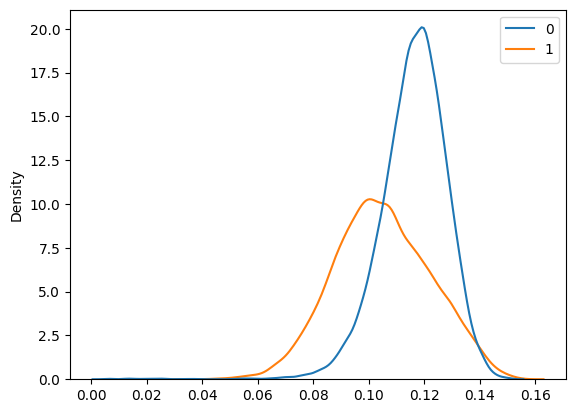

In [57]:
sns.kdeplot([gfn_mean_sim_per_mol, drugex_mean_sim_per_mol])

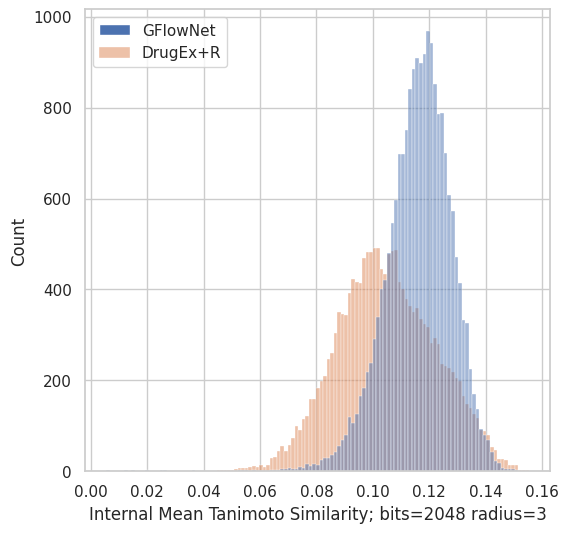

In [141]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel("Internal Mean Tanimoto Similarity; bits=2048 radius=3")
sns.histplot([gfn_mean_sim_per_mol, drugex_mean_sim_per_mol], ax=ax)
ax.legend(labels=["GFlowNet", "DrugEx+R"])
plt.savefig("../reports/internal_mean_tanimoto_drugex_base.png")

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel("Internal Median Tanimoto Similarity")
sns.histplot([gfn_median_sim_per_mol, drugex_median_sim_per_mol], ax=ax)
ax.legend(labels=["GFlowNet", "DrugEx+R"])
plt.savefig("../reports/internal_median_tanimoto_drugex_base.png")

In [139]:
d = {"GFlowNet":gfn_mean_sim_per_mol, "DrugEx+R":drugex_mean_sim_per_mol}
data = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))

Text(0, 0.5, 'Internal Mean Tanimoto Similarity')

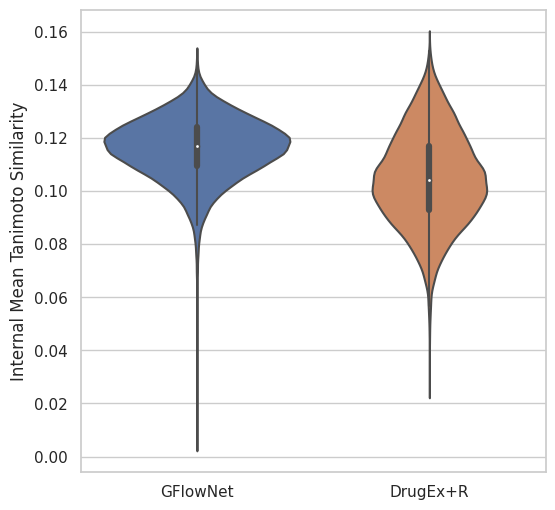

In [140]:
plt.close()
fig, ax = plt.subplots(figsize=(6, 6))
# sns.violinplot([gfn_mean_sim_per_mol, drugex_mean_sim_per_mol], ax=ax)
sns.violinplot(data, ax=ax)
ax.set_ylabel('Internal Mean Tanimoto Similarity')


[(0.0, 80000.0), Text(0, 0.5, ''), Text(0.5, 0, '# Sampled Molecules')]

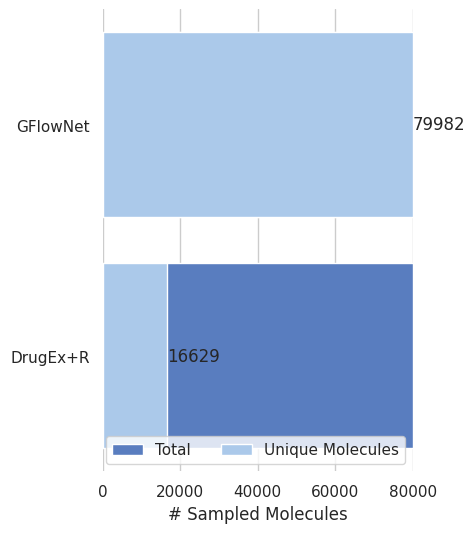

In [119]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
fig, ax = plt.subplots(figsize=(4, 6))

sns.set_color_codes("muted")
data = pd.DataFrame({"GFlowNet": [80_000], "DrugEx+R": [80_000]})
sns.barplot(data, orient='h', color="b", label="Total")
sns.set_color_codes("pastel")
data = pd.DataFrame({"GFlowNet": [79982], "DrugEx+R": [16629]})
sns.barplot(data, orient='h', color="b", label="Unique Molecules")
# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
sns.despine(left=True, bottom=True)
ax.bar_label(ax.containers[1])
ax.set(xlim=(0, 80_000), ylabel="",
       xlabel="# Sampled Molecules")

In [120]:
def change_width_horizontal(ax, new_value) :
    
    for patch in ax.patches :
        
        current_height = patch.get_height()
        diff = current_height - new_value

        # we change the bar width
        patch.set_height(new_value)

        # we recenter the bar
        patch.set_y(patch.get_y() + diff * .5)

In [121]:
change_width_horizontal(ax=ax, new_value=0.1)

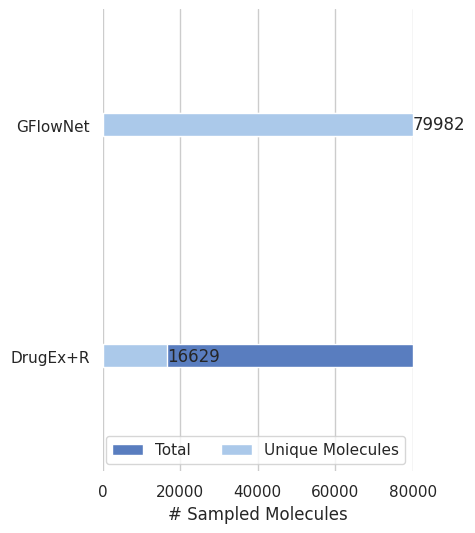

In [122]:
fig

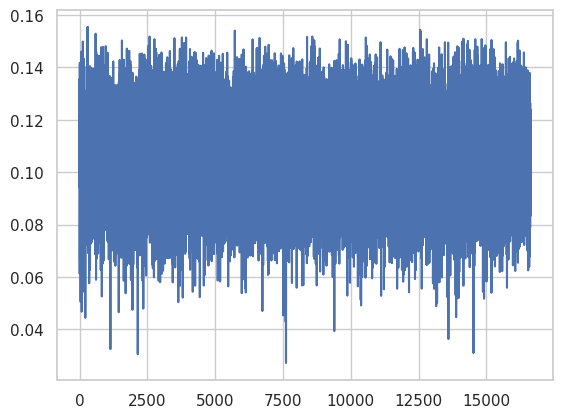

In [123]:
plt.plot(drugex_mean_sim_per_mol)

In [64]:
np.median(gfn_base_sims)

0.11042944785276074

In [65]:
np.median(drugex_base_sims)

0.09352517985611511